# Supervised Learning of Drug Response using CORES from Copy Number Log Ratio

### Import Python source code

In [26]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 26 12:21:38 2018

@author: bbece
"""

from __future__ import division, print_function, unicode_literals
import numpy as np
import os
from IPython.display import display, HTML

from pprint import pprint
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
            
import pandas as pd
import scipy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler

from sklearn import decomposition

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.tree import export_graphviz

import math



### Define method to split training and testing set

In [27]:
# TODO: Manipulate test_ratio
def split_train_test(training_set, test_ratio = 0.33):
    row_count = training_set.shape[0]
    shuffled_indices = np.random.permutation(row_count)
    test_set_size = int(test_ratio * row_count)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return training_set.iloc[train_indices], training_set.iloc[test_indices]

### Load training set matrix

In [54]:
#labeled_matrix_training_set = pd.read_csv("../mlOutput/geneTrainingSet_8_5_2018_1.csv") # Cancer gene feature set
#labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_3_2018_1.csv") # Slicing features on A and D combined
labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_2_2018_2.csv") # Segment features on A and D combined
#labeled_matrix_training_set = pd.read_csv("../mlOutput/coreTrainingSet_8_2_2018_1.csv") # Segment features on A and D merged
#labeled_matrix_training_set.columns.values[0] = "sampleId"
labeled_matrix_training_set = labeled_matrix_training_set.drop([labeled_matrix_training_set.columns[0]], axis = 1)
labels = list(range(0,5))


In [55]:
display(labeled_matrix_training_set.head(25))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin,1,3,8,9,16,...,65,67,68,69,70,72,73,74,77,80
0,0.576312,0.715357,0.542345,0.770327,0.875863,0.436093,0.219046,0.093381,0.306327,-0.850429,...,0.091356,-0.020526,0.305247,-0.097172,0.091364,-0.936458,-0.861014,-0.953599,0.979149,-0.069036
1,0.531357,0.481223,0.552329,0.778592,0.802963,0.522301,0.332260,0.036914,0.233745,-0.951033,...,0.037372,-0.353375,-0.111128,-0.611878,-0.351904,-0.289993,-0.324749,-0.375740,-0.263046,-0.427196
2,0.610292,0.748410,0.544124,0.673957,0.790218,0.395108,-0.059497,-0.056061,0.109607,-1.585542,...,-0.121145,-0.175617,-0.052702,-0.425628,0.049563,-0.543270,-0.536459,-0.642908,0.251044,0.088374
3,0.677571,0.647227,0.562632,0.826889,0.835748,0.132817,0.529099,-0.040379,0.202314,-0.619159,...,0.414758,0.183085,0.685537,0.189467,0.549099,-0.637489,-0.642251,-0.772321,0.572187,-1.629346
4,0.694529,0.653745,0.651769,0.850960,0.813800,0.207992,0.265925,0.114829,0.234293,-0.879316,...,0.136851,0.510556,0.287325,0.589296,0.824069,0.011819,-0.754368,-0.047061,0.572734,-1.053957
5,0.625919,0.546421,0.570326,0.723314,0.943585,0.099434,0.458407,0.783488,0.953391,-0.255512,...,-0.189842,-0.323942,-0.132488,-0.580421,-0.107210,-0.253809,-0.300951,-0.355237,1.404891,0.196116
6,0.619415,0.566868,0.548342,0.755120,0.841761,-0.960577,0.375832,-0.173501,0.123302,-0.562097,...,0.025176,-0.390782,-1.956893,-1.476872,-1.255124,0.184695,0.159322,0.046950,-0.203930,-0.807023
7,0.557171,0.577914,0.611604,0.895087,0.914860,-0.334538,0.416808,0.317006,0.459243,-1.689432,...,0.371994,-0.222975,0.139134,-0.357164,-0.004910,-0.180432,-0.212158,-0.218690,0.410748,-1.764445
8,0.821077,0.698895,0.790806,NaN,NaN,-0.557269,0.301038,0.195996,0.364016,-0.690727,...,0.273373,0.029492,0.520527,-0.305875,0.234380,0.191366,0.088789,0.084635,-0.158168,-0.735119
9,NaN,NaN,NaN,NaN,NaN,0.472155,-0.079524,0.286920,0.462819,-0.417980,...,-0.244722,-0.314863,-0.243135,-0.440525,-0.080551,-0.213000,-0.366078,0.475861,0.663687,-0.376184


In [44]:
X = labeled_matrix_training_set.copy().drop(labeled_matrix_training_set.columns[labels], axis = 1)
y = labeled_matrix_training_set.copy()[labeled_matrix_training_set.columns[labels]]

In [45]:
display(X.head())

,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,KRAS,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
0,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,0.038580,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854
1,0.463318,-0.332190,0.226877,-0.240739,-0.973241,-0.334562,-0.242026,1.636246,-0.706995,-0.026589,...,0.255607,0.225913,0.225913,-0.256202,0.179031,0.526987,0.226877,0.425506,-0.330152,-0.255410
2,0.566340,-0.589751,0.566340,-0.794380,-1.594234,-0.819717,0.238720,0.715618,-0.104585,0.201630,...,-0.173821,0.047661,0.047661,0.557542,0.012622,0.825662,0.566340,0.548530,-0.320209,0.351739
3,-0.243281,-0.597811,-0.243281,0.252588,-0.494849,-0.770950,-1.530490,0.339811,0.254311,-0.108786,...,0.354180,0.174530,0.173222,0.389187,-0.680256,0.231183,-0.243281,-0.070620,-0.257258,0.694761
4,-0.031502,-0.040405,-0.031502,0.070919,-0.790087,-0.934074,-0.869327,0.093761,0.552080,0.008100,...,0.056422,0.041050,0.041050,0.072801,0.014393,0.075673,-0.031502,0.014393,-1.011516,0.667773


In [46]:
display(y.head(15))

,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
0,0.576312,0.715357,0.542345,0.770327,0.875863
1,0.531357,0.481223,0.552329,0.778592,0.802963
2,0.610292,0.748410,0.544124,0.673957,0.790218
3,0.677571,0.647227,0.562632,0.826889,0.835748
4,0.694529,0.653745,0.651769,0.850960,0.813800
5,0.625919,0.546421,0.570326,0.723314,0.943585
6,0.619415,0.566868,0.548342,0.755120,0.841761
7,0.557171,0.577914,0.611604,0.895087,0.914860
8,0.821077,0.698895,0.790806,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [47]:
from sklearn.model_selection import train_test_split

all_X_TRAIN, all_X_TEST, all_Y_TRAIN, all_Y_TEST = train_test_split(X, y, test_size=0.20, random_state=42)
# TODO: train_test must be split on amount of NAs as well!

In [48]:
display(all_X_TRAIN.head())
display(all_Y_TRAIN.head())

,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,KRAS,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
65,0.086752,-0.851427,0.086752,0.164449,-0.792466,-0.820878,-0.787761,0.212358,0.083198,-0.186574,...,0.133240,0.245965,0.072348,-0.256036,-0.863858,0.296249,0.086752,0.653934,-0.935416,0.120532
15,0.143449,-0.067964,0.143449,0.020146,-0.802435,-0.962963,-4.196508,0.650266,-0.028750,-0.011984,...,0.032173,0.023881,0.023881,0.040950,-0.004241,0.036148,0.143449,-0.004241,-1.051368,0.400350
68,-0.020544,0.482965,-0.020544,0.075696,-0.797461,-0.955926,0.055713,0.210702,0.012291,0.077271,...,0.065207,0.070398,0.070398,-0.845527,0.043855,0.076861,-0.020544,0.043855,-0.055865,0.068069
78,-0.066307,0.009959,-0.066307,0.010423,0.092880,-0.066307,0.005092,0.092880,-0.040114,-0.020887,...,0.001569,0.011817,0.011817,0.063211,-0.026483,0.454632,-0.066307,-0.026483,-0.117882,0.038849
30,-0.154674,-0.232101,-0.222955,-0.014822,-0.616782,-0.725121,-0.682573,0.316372,0.387433,0.226481,...,0.085986,-0.144294,-0.144294,0.253875,0.195634,0.375740,-0.222955,0.138105,-0.154725,0.569999


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
65,0.649721,0.588074,0.647026,0.898595,0.907493
15,0.604702,0.564116,0.560100,0.724743,0.875436
68,0.574839,0.585097,0.554903,NaN,0.791185
78,NaN,NaN,NaN,NaN,NaN
30,0.637520,0.652945,0.679371,0.822522,0.927028


In [49]:
display(all_X_TEST.head())
display(all_Y_TEST.head())

,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,KRAS,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
40,-0.036055,0.120993,-0.036055,-0.112546,0.121339,-0.036055,0.078198,0.121339,0.097597,-0.014723,...,0.208510,0.012825,0.012825,0.123312,0.028185,-0.054596,-0.036055,0.165754,0.039105,0.103813
22,-0.687761,-0.168264,-0.687761,0.610562,0.413320,-0.687761,-0.594423,0.413320,-0.665786,0.441350,...,-0.069208,0.745745,0.540231,-0.043792,-0.675757,0.321580,-0.687761,-0.109327,-0.127176,-0.507996
55,0.082445,-0.003601,0.082445,-0.865438,0.149928,-0.835642,-0.851518,0.149928,0.038660,0.068444,...,0.096341,0.097715,0.097715,0.089291,0.045415,0.156436,0.082445,0.045415,0.045845,0.092587
72,0.100338,0.052908,0.100338,0.129213,-0.665488,-0.807643,-0.363904,0.239146,0.676986,0.147273,...,0.166784,0.738439,-0.748457,-0.164248,0.120998,0.201094,0.100338,0.120998,-0.881308,0.542118
0,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,0.038580,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854


,Gemcitabine,Paclitaxel,SN-38,5-FU,Oxaliplatin
40,NaN,NaN,NaN,NaN,NaN
22,0.915466,0.756732,0.877780,0.963176,1.000000
55,0.518635,0.545283,0.489531,0.726636,0.746754
72,0.628506,0.538041,0.581497,0.696855,0.703624
0,0.576312,0.715357,0.542345,0.770327,0.875863


## Visualize ML Results

In [50]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [51]:
def retrieve_pipelines(model_name, ml_model):
    Ypipeline = Pipeline([
     ('imputer', Imputer(axis=0,strategy="median")),
     ('scaler', StandardScaler()),
    #('scaler', MinMaxScaler())
    ])

    XYpipeline = Pipeline([
            ('imputer', Imputer(axis=0,strategy="median")),
            ('scaler', StandardScaler()),
            #('scaler', MinMaxScaler()),
            #("pca", decomposition.PCA(n_components=10)),
            (model_name,  ml_model)
    ])
    
    return (Ypipeline, XYpipeline)

def imputer_inverse_transform(pre_data, post_data):
    na_indices = np.where(np.isnan(pre_data))[0]
    post_data[na_indices] = float('NaN')
    return post_data
    
def remove_NAs(X, y, label):
    label_y = y[[y.columns[label]]]
    na_indices = label_y[label_y.columns[0]].index[label_y[label_y.columns[0]].apply(np.isnan)]
    y_nonNA = label_y.copy().drop(na_indices)
    X_nonNA = X.copy().drop(na_indices)
    return X_nonNA, y_nonNA
    
def train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, this_y_train, this_y_test):
    this_y_train_tr = Ypipeline.fit_transform(this_y_train)
    XYpipeline.fit(X_TRAIN,this_y_train_tr)

    y_test_tr = Ypipeline.transform(this_y_test)
    y_prediction = XYpipeline.predict(X_TEST)

    y_prediction = Ypipeline.named_steps['scaler'].inverse_transform(y_prediction)
    y_prediction = imputer_inverse_transform(this_y_test, y_prediction)

    y_test_np = this_y_test
    y_test_np = y_test_np[~np.isnan(y_test_np)]
    y_prediction = y_prediction[~np.isnan(y_prediction)]
    return (y_test_np, y_prediction, this_y_train_tr)


def simple_score(y_test_np, y_prediction):
    rmse = np.sqrt(mean_squared_error(y_test_np, y_prediction))
    r = scipy.stats.pearsonr(y_test_np, y_prediction)
    t = scipy.stats.spearmanr(y_test_np, y_prediction)
    return (rmse, r, t)
    
def visualize(y_test_np, y_prediction):
    plt.plot(y_test_np, y_prediction, 'bo')
    abline(1,0)
    plt.ylabel("Prediction")
    plt.xlabel("Label")
    plt.show()
    
def display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST):
    TRAIN = pd.concat([Y_TRAIN, X_TRAIN], axis=1)
    TEST = pd.concat([Y_TEST, X_TEST], axis=1)
    pprint("TRAIN")
    display(TRAIN)
    pprint("TEST")
    display(TEST)

def cv_score(XYpipeline, X_TRAIN, this_y_train_tr):
    scores = cross_val_score(XYpipeline, X_TRAIN, this_y_train_tr,
                             scoring = "neg_mean_squared_error", cv=10)
    scores = Ypipeline.named_steps['normalizer'].inverse_transform(scores)
    return scores


### Visualize ML results using Linear Regression

'TRAIN'


,Gemcitabine,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
19,0.680200,0.027393,-0.543165,0.027393,0.270013,-1.429431,-0.727629,-1.352894,0.015393,-0.451992,...,-0.072607,0.420460,-1.316621,0.463309,-0.213237,0.124904,0.027393,0.298176,-0.533831,1.557450
64,0.595509,-0.012868,0.047372,-0.012868,-0.888016,-0.777683,-0.935657,-0.840856,0.128660,0.025474,...,0.696931,0.068836,0.068836,0.091332,-0.953096,0.092601,-0.012868,0.609261,0.001875,0.093665
26,0.741899,-0.087993,-0.481853,-0.087993,0.379758,-1.404059,-0.621987,-0.531713,0.402596,0.318321,...,-0.001358,0.367263,0.367263,0.345299,-5.145469,0.042251,-0.087993,0.363623,-0.678297,0.444689
51,0.645679,-0.051102,-0.634563,-0.051102,0.408911,-0.423337,-0.592335,-0.640060,-0.423337,0.393275,...,0.003425,0.444855,-0.002862,0.070373,-0.551927,0.461309,-0.051102,0.370142,-0.614964,0.480710
2,0.610292,0.566340,-0.589751,0.566340,-0.794380,-1.594234,-0.819717,0.238720,0.715618,-0.104585,...,-0.173821,0.047661,0.047661,0.557542,0.012622,0.825662,0.566340,0.548530,-0.320209,0.351739
62,0.736810,0.460942,-0.534591,0.460942,-0.409876,-0.362262,-0.472703,-0.417341,-0.362262,-0.478336,...,0.132005,-0.428548,-0.428548,0.514538,0.088936,0.561241,0.460942,0.088936,-0.444778,0.762311
24,0.622163,-0.156418,-0.934739,-0.192056,0.465939,-0.007093,-1.061507,-0.031043,-0.007093,-0.178400,...,0.436394,0.936001,-0.982212,-0.175701,-0.155148,0.861397,-0.192056,0.786487,-0.537990,0.595749
17,0.620575,0.135596,-0.306661,0.135596,0.250250,-0.634707,-0.761605,-0.518442,0.340132,0.144331,...,0.228484,-0.098005,-0.098005,0.138078,-0.789171,0.319532,0.135596,0.192220,-0.241952,-0.258214
93,0.591477,-0.863421,-0.006058,0.007567,0.204189,-0.861453,-0.855914,-0.776960,0.121456,0.055273,...,0.124049,0.125803,0.125803,0.019619,-0.893810,0.169023,0.007567,0.098383,0.022979,0.550465
38,0.659406,-0.052143,-0.064653,-0.052143,0.068681,-0.834527,-0.960793,0.074921,0.135028,-0.004466,...,0.601841,0.066401,-0.949093,0.066245,0.010764,0.616187,-0.052143,0.030825,-0.993734,0.653767


'TEST'


,Gemcitabine,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
30,0.637520,-0.154674,-0.232101,-0.222955,-0.014822,-0.616782,-0.725121,-0.682573,0.316372,0.387433,...,0.085986,-0.144294,-0.144294,0.253875,0.195634,0.375740,-0.222955,0.138105,-0.154725,0.569999
55,0.518635,0.082445,-0.003601,0.082445,-0.865438,0.149928,-0.835642,-0.851518,0.149928,0.038660,...,0.096341,0.097715,0.097715,0.089291,0.045415,0.156436,0.082445,0.045415,0.045845,0.092587
31,0.744417,0.081446,0.046019,0.081446,-0.395810,-0.331859,-0.407638,-0.370746,-0.335137,-0.449285,...,0.172588,0.161813,0.161813,-0.391410,-0.431258,0.587556,0.081446,0.523263,0.089342,0.550507
15,0.604702,0.143449,-0.067964,0.143449,0.020146,-0.802435,-0.962963,-4.196508,0.650266,-0.028750,...,0.032173,0.023881,0.023881,0.040950,-0.004241,0.036148,0.143449,-0.004241,-1.051368,0.400350
37,0.719214,-0.392842,-0.354415,-0.302484,-0.350955,-0.245918,-0.393558,-0.325803,-0.245918,-0.367840,...,-0.323704,0.412507,-0.287018,1.300455,-0.403672,0.504925,0.503716,0.146761,-0.459272,0.599997
70,0.790540,-0.038424,0.085582,0.100625,0.247720,-0.634960,0.100625,-0.640472,0.800277,0.114773,...,-0.737542,0.261146,0.261146,0.307835,0.123319,0.271900,-0.038424,0.123319,-0.801357,0.274833
87,0.777284,-0.647540,-0.723645,-0.647540,0.222875,-0.469980,-0.647540,-0.637160,0.257577,0.156419,...,0.200790,0.201999,0.201999,0.218235,-0.498886,0.325844,-0.647540,0.261756,-0.725328,0.091415
59,0.587329,-0.127138,0.220051,-0.127138,-0.021930,-0.579671,-0.652698,-1.479701,0.314225,0.240669,...,0.309550,0.680145,-0.075069,0.292756,-0.664100,0.340519,-0.127138,-0.109071,-0.661613,0.307169
3,0.677571,-0.243281,-0.597811,-0.243281,0.252588,-0.494849,-0.770950,-1.530490,0.339811,0.254311,...,0.354180,0.174530,0.173222,0.389187,-0.680256,0.231183,-0.243281,-0.070620,-0.257258,0.694761
85,0.594579,-0.113416,-1.018712,-0.125090,-0.012672,-0.884930,-0.074905,-0.013748,0.068379,-0.054395,...,0.003320,0.001122,0.001122,0.028633,-0.036298,-0.013828,-0.125090,-1.013248,-1.299235,0.012843


RMSE: 0.0894737359709
Pearson: (0.20414184735459001, 0.50350809447863354)
Spearman: SpearmanrResult(correlation=0.12087912087912088, pvalue=0.69404732799668567)


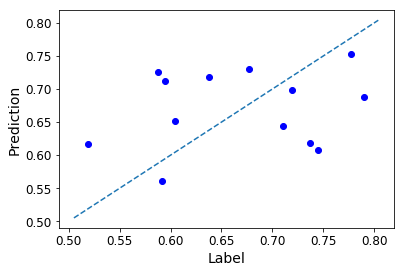

'TRAIN'


,Paclitaxel,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
14,0.628936,0.005322,-0.030732,0.005322,0.085692,0.137097,0.005322,-0.928042,0.137097,0.020967,...,0.055584,0.072988,0.072988,0.089219,-0.919188,0.081243,0.005322,0.042071,-0.013083,0.079147
19,0.577722,0.027393,-0.543165,0.027393,0.270013,-1.429431,-0.727629,-1.352894,0.015393,-0.451992,...,-0.072607,0.420460,-1.316621,0.463309,-0.213237,0.124904,0.027393,0.298176,-0.533831,1.557450
37,0.706000,-0.392842,-0.354415,-0.302484,-0.350955,-0.245918,-0.393558,-0.325803,-0.245918,-0.367840,...,-0.323704,0.412507,-0.287018,1.300455,-0.403672,0.504925,0.503716,0.146761,-0.459272,0.599997
49,0.575363,-0.020034,-0.961592,-0.020034,0.074847,-0.803470,-0.942163,-0.772674,-0.031977,0.204102,...,0.057633,0.060901,0.060901,0.031999,0.236475,0.328670,-0.020034,0.236475,-0.001518,0.088920
32,0.697379,0.088577,0.048355,0.088577,0.181035,-0.343950,-0.450134,-0.389765,-0.343950,0.096573,...,0.163542,0.085605,0.085605,-0.417234,-0.445309,0.584467,0.088577,0.505502,-0.481497,0.543635
66,0.518664,0.119767,0.117106,0.125298,-0.011011,-0.649209,-0.801089,-4.708567,0.269753,-0.088666,...,-1.123365,0.274711,0.147736,0.111191,-0.567861,0.214383,0.051350,0.434780,-0.819149,0.775192
29,0.707878,0.029959,0.318227,-0.037934,-0.054207,-0.764015,-0.803408,0.065922,0.200720,-0.008995,...,-0.812448,0.147939,-0.074936,-0.421161,-0.864290,0.032801,-0.037934,0.375272,-0.980785,0.425974
62,0.685397,0.460942,-0.534591,0.460942,-0.409876,-0.362262,-0.472703,-0.417341,-0.362262,-0.478336,...,0.132005,-0.428548,-0.428548,0.514538,0.088936,0.561241,0.460942,0.088936,-0.444778,0.762311
15,0.564116,0.143449,-0.067964,0.143449,0.020146,-0.802435,-0.962963,-4.196508,0.650266,-0.028750,...,0.032173,0.023881,0.023881,0.040950,-0.004241,0.036148,0.143449,-0.004241,-1.051368,0.400350
4,0.653745,-0.031502,-0.040405,-0.031502,0.070919,-0.790087,-0.934074,-0.869327,0.093761,0.552080,...,0.056422,0.041050,0.041050,0.072801,0.014393,0.075673,-0.031502,0.014393,-1.011516,0.667773


'TEST'


,Paclitaxel,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
64,0.593731,-0.012868,0.047372,-0.012868,-0.888016,-0.777683,-0.935657,-0.840856,0.128660,0.025474,...,0.696931,0.068836,0.068836,0.091332,-0.953096,0.092601,-0.012868,0.609261,0.001875,0.093665
35,0.555007,-0.714736,-0.648772,-0.721877,0.297124,-0.559314,-0.695849,-0.631595,-0.559314,0.260243,...,-0.094369,0.334178,-0.675151,1.408859,-0.686627,0.319508,0.478637,0.598293,-0.187694,0.640989
34,0.614227,0.060279,0.032217,0.060279,-0.356293,-0.351909,-0.453616,-0.408758,-0.351909,0.046640,...,0.145157,0.123357,0.123357,-0.409267,-0.409423,0.552771,0.060279,0.478386,-0.493038,0.519174
72,0.538041,0.100338,0.052908,0.100338,0.129213,-0.665488,-0.807643,-0.363904,0.239146,0.676986,...,0.166784,0.738439,-0.748457,-0.164248,0.120998,0.201094,0.100338,0.120998,-0.881308,0.542118
0,0.715357,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854
84,0.589626,0.353739,-0.619910,0.353739,0.027911,-1.286362,-0.550712,-0.441061,-1.284279,0.022348,...,-0.433284,0.505116,-0.494379,-0.401544,-0.538279,0.515756,0.353739,0.041120,-0.558424,1.510324
6,0.566868,0.151620,0.166565,0.151620,0.058378,-0.510946,-0.786721,-0.616592,0.434166,0.163978,...,0.176326,0.192074,0.192074,0.277968,0.092862,0.243589,0.151620,0.092862,-0.152091,-0.115525
48,0.574002,-0.349416,0.335585,0.349797,-0.255805,-0.810489,-0.886640,-0.285123,-0.810489,0.338413,...,0.306817,0.538407,0.331331,-0.025380,-0.353175,0.716334,-0.457964,0.305106,-0.337257,1.246137
69,0.567934,0.151161,-0.202464,0.151161,0.149548,-0.666433,-0.819462,-4.797616,1.341327,0.124778,...,-0.138331,0.175487,0.175487,-0.100306,0.182718,0.787357,0.151161,0.182718,-0.191201,0.179012
26,0.596468,-0.087993,-0.481853,-0.087993,0.379758,-1.404059,-0.621987,-0.531713,0.402596,0.318321,...,-0.001358,0.367263,0.367263,0.345299,-5.145469,0.042251,-0.087993,0.363623,-0.678297,0.444689


RMSE: 0.0846927994999
Pearson: (-0.028590675739959513, 0.92612940729524307)
Spearman: SpearmanrResult(correlation=-0.0054945054945054941, pvalue=0.98578691071406233)


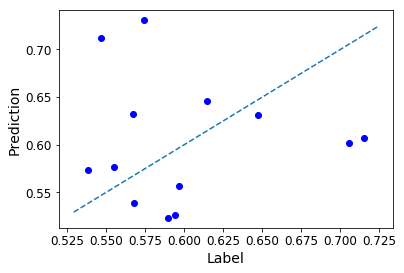

'TRAIN'


,SN-38,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
67,0.602269,-0.461671,0.059738,-0.461671,-0.397129,-0.312624,-0.461671,-0.394596,-0.312624,-0.427314,...,0.154809,0.167920,0.167920,-0.369718,0.130418,0.566756,-0.461671,0.130418,-1.317015,0.172944
0,0.542345,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854
23,0.491755,0.048564,-0.152602,0.048564,0.344240,-1.498079,-0.651957,-0.487487,-0.166071,0.152892,...,-0.140271,0.376224,-0.087151,-0.080004,-0.661116,0.358696,0.048564,-0.095923,-0.673797,-0.094925
65,0.647026,0.086752,-0.851427,0.086752,0.164449,-0.792466,-0.820878,-0.787761,0.212358,0.083198,...,0.133240,0.245965,0.072348,-0.256036,-0.863858,0.296249,0.086752,0.653934,-0.935416,0.120532
27,0.668818,0.076952,-0.850313,0.037689,0.173123,-0.732659,-0.839091,-0.792946,0.182014,0.087178,...,0.129737,0.104021,0.104021,-0.829159,-0.892941,0.729033,0.037689,0.087438,-0.868644,0.206997
19,0.602164,0.027393,-0.543165,0.027393,0.270013,-1.429431,-0.727629,-1.352894,0.015393,-0.451992,...,-0.072607,0.420460,-1.316621,0.463309,-0.213237,0.124904,0.027393,0.298176,-0.533831,1.557450
62,0.583725,0.460942,-0.534591,0.460942,-0.409876,-0.362262,-0.472703,-0.417341,-0.362262,-0.478336,...,0.132005,-0.428548,-0.428548,0.514538,0.088936,0.561241,0.460942,0.088936,-0.444778,0.762311
2,0.544124,0.566340,-0.589751,0.566340,-0.794380,-1.594234,-0.819717,0.238720,0.715618,-0.104585,...,-0.173821,0.047661,0.047661,0.557542,0.012622,0.825662,0.566340,0.548530,-0.320209,0.351739
59,0.558598,-0.127138,0.220051,-0.127138,-0.021930,-0.579671,-0.652698,-1.479701,0.314225,0.240669,...,0.309550,0.680145,-0.075069,0.292756,-0.664100,0.340519,-0.127138,-0.109071,-0.661613,0.307169
30,0.679371,-0.154674,-0.232101,-0.222955,-0.014822,-0.616782,-0.725121,-0.682573,0.316372,0.387433,...,0.085986,-0.144294,-0.144294,0.253875,0.195634,0.375740,-0.222955,0.138105,-0.154725,0.569999


'TEST'


,SN-38,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
7,0.611604,0.130872,-0.214090,0.130872,0.284643,-1.540337,-0.691314,-1.599590,-1.540337,-0.166528,...,-0.685718,0.278768,0.278768,0.246764,-0.720195,0.331348,0.130872,0.247601,-0.773288,0.301806
26,0.655725,-0.087993,-0.481853,-0.087993,0.379758,-1.404059,-0.621987,-0.531713,0.402596,0.318321,...,-0.001358,0.367263,0.367263,0.345299,-5.145469,0.042251,-0.087993,0.363623,-0.678297,0.444689
25,0.579003,-0.114785,-0.766630,-0.114785,-0.014794,-0.942306,-0.114785,-0.020771,0.076786,-0.077897,...,-0.037696,-0.021466,-0.021466,0.009035,-0.080904,-0.037473,-0.114785,0.512414,-0.108519,0.554319
89,0.610227,-0.012601,-0.006561,-0.012601,0.111773,-0.724117,-0.796885,-0.638010,0.642113,0.100225,...,0.101900,0.083214,0.083214,0.100712,0.065016,0.114578,-0.012601,0.995670,0.035621,0.160703
21,0.621525,-0.624372,-0.696986,-0.624372,0.644341,-1.404413,-0.624372,-0.471252,0.165918,-0.061169,...,0.000564,0.997109,-0.526829,0.412547,0.371748,0.340259,-0.624372,0.365421,-0.114467,0.957819
49,0.557068,-0.020034,-0.961592,-0.020034,0.074847,-0.803470,-0.942163,-0.772674,-0.031977,0.204102,...,0.057633,0.060901,0.060901,0.031999,0.236475,0.328670,-0.020034,0.236475,-0.001518,0.088920
16,0.720942,0.017521,-0.945842,0.017521,0.088437,-0.735902,-0.897756,-0.840457,0.158708,0.066237,...,0.111495,0.103504,0.103504,0.139750,-0.215921,0.245245,0.017521,0.108563,-0.937334,0.138085
81,0.602550,0.111113,-0.279427,0.111113,0.223442,-1.598806,-0.788369,-0.711756,-0.040352,-0.745530,...,0.246913,0.469116,-0.201600,0.218948,-0.199229,0.227719,0.111113,-0.199229,-0.222383,0.788834
4,0.651769,-0.031502,-0.040405,-0.031502,0.070919,-0.790087,-0.934074,-0.869327,0.093761,0.552080,...,0.056422,0.041050,0.041050,0.072801,0.014393,0.075673,-0.031502,0.014393,-1.011516,0.667773
6,0.548342,0.151620,0.166565,0.151620,0.058378,-0.510946,-0.786721,-0.616592,0.434166,0.163978,...,0.176326,0.192074,0.192074,0.277968,0.092862,0.243589,0.151620,0.092862,-0.152091,-0.115525


RMSE: 0.0793512609444
Pearson: (0.079868970347443766, 0.79535081006083952)
Spearman: SpearmanrResult(correlation=0.17032967032967034, pvalue=0.57797542883926734)


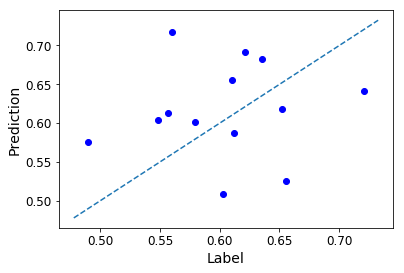

'TRAIN'


,5-FU,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
14,0.831634,0.005322,-0.030732,0.005322,0.085692,0.137097,0.005322,-0.928042,0.137097,0.020967,...,0.055584,0.072988,0.072988,0.089219,-0.919188,0.081243,0.005322,0.042071,-0.013083,0.079147
18,0.727964,0.132319,-0.253738,0.132319,0.199560,-1.575238,-0.737578,-4.994624,0.264323,0.147926,...,-0.143308,0.234535,0.234535,0.235307,-0.685288,0.240842,0.132319,0.273304,-0.210431,0.266274
0,0.770327,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854
2,0.673957,0.566340,-0.589751,0.566340,-0.794380,-1.594234,-0.819717,0.238720,0.715618,-0.104585,...,-0.173821,0.047661,0.047661,0.557542,0.012622,0.825662,0.566340,0.548530,-0.320209,0.351739
16,0.849164,0.017521,-0.945842,0.017521,0.088437,-0.735902,-0.897756,-0.840457,0.158708,0.066237,...,0.111495,0.103504,0.103504,0.139750,-0.215921,0.245245,0.017521,0.108563,-0.937334,0.138085
35,0.655291,-0.714736,-0.648772,-0.721877,0.297124,-0.559314,-0.695849,-0.631595,-0.559314,0.260243,...,-0.094369,0.334178,-0.675151,1.408859,-0.686627,0.319508,0.478637,0.598293,-0.187694,0.640989
33,0.641945,0.042932,0.006260,0.042932,-0.408587,0.110811,-0.475180,-0.373749,0.110811,0.376944,...,0.136926,0.560028,0.085808,-0.436133,-0.471923,0.725885,0.042932,0.463375,-0.504340,0.206408
80,0.778938,-0.500974,-0.107925,-0.500974,0.816153,-1.413008,-0.552127,-0.482102,0.175856,-0.392976,...,-0.026517,0.302397,0.302397,0.398799,-0.113278,0.496564,-0.500974,0.327621,-0.180671,0.461373
21,0.754820,-0.624372,-0.696986,-0.624372,0.644341,-1.404413,-0.624372,-0.471252,0.165918,-0.061169,...,0.000564,0.997109,-0.526829,0.412547,0.371748,0.340259,-0.624372,0.365421,-0.114467,0.957819
19,0.742902,0.027393,-0.543165,0.027393,0.270013,-1.429431,-0.727629,-1.352894,0.015393,-0.451992,...,-0.072607,0.420460,-1.316621,0.463309,-0.213237,0.124904,0.027393,0.298176,-0.533831,1.557450


'TEST'


,5-FU,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
69,0.762266,0.151161,-0.202464,0.151161,0.149548,-0.666433,-0.819462,-4.797616,1.341327,0.124778,...,-0.138331,0.175487,0.175487,-0.100306,0.182718,0.787357,0.151161,0.182718,-0.191201,0.179012
70,0.875244,-0.038424,0.085582,0.100625,0.247720,-0.634960,0.100625,-0.640472,0.800277,0.114773,...,-0.737542,0.261146,0.261146,0.307835,0.123319,0.271900,-0.038424,0.123319,-0.801357,0.274833
10,0.800295,-0.211088,-0.788262,-0.779782,0.264241,-0.622085,-0.751206,-0.697975,0.272377,0.192339,...,0.249699,0.561605,-0.164773,0.287506,0.204379,0.587367,-0.779782,0.204379,-0.193646,0.238656
84,0.615629,0.353739,-0.619910,0.353739,0.027911,-1.286362,-0.550712,-0.441061,-1.284279,0.022348,...,-0.433284,0.505116,-0.494379,-0.401544,-0.538279,0.515756,0.353739,0.041120,-0.558424,1.510324
50,0.845183,0.286718,-1.576893,0.674587,0.692968,-0.156040,-0.643627,-0.541235,-0.156040,-0.063084,...,-0.082957,0.352909,0.352909,0.017448,-0.139133,0.077701,0.674587,0.648257,0.048668,-0.535573
59,0.853513,-0.127138,0.220051,-0.127138,-0.021930,-0.579671,-0.652698,-1.479701,0.314225,0.240669,...,0.309550,0.680145,-0.075069,0.292756,-0.664100,0.340519,-0.127138,-0.109071,-0.661613,0.307169
85,0.778166,-0.113416,-1.018712,-0.125090,-0.012672,-0.884930,-0.074905,-0.013748,0.068379,-0.054395,...,0.003320,0.001122,0.001122,0.028633,-0.036298,-0.013828,-0.125090,-1.013248,-1.299235,0.012843
22,0.963176,-0.687761,-0.168264,-0.687761,0.610562,0.413320,-0.687761,-0.594423,0.413320,-0.665786,...,-0.069208,0.745745,0.540231,-0.043792,-0.675757,0.321580,-0.687761,-0.109327,-0.127176,-0.507996
25,0.776366,-0.114785,-0.766630,-0.114785,-0.014794,-0.942306,-0.114785,-0.020771,0.076786,-0.077897,...,-0.037696,-0.021466,-0.021466,0.009035,-0.080904,-0.037473,-0.114785,0.512414,-0.108519,0.554319
36,0.686940,-0.095374,-0.932848,-0.189183,0.072031,0.183853,-0.133161,-0.850514,-0.203573,-0.052652,...,-0.023662,0.511466,-0.234993,1.436124,-0.843295,0.638713,0.666291,-0.006116,-0.913696,0.516436


RMSE: 0.107661465781
Pearson: (0.39159329080048338, 0.2080825584427399)
Spearman: SpearmanrResult(correlation=0.39160839160839161, pvalue=0.2080634636953532)


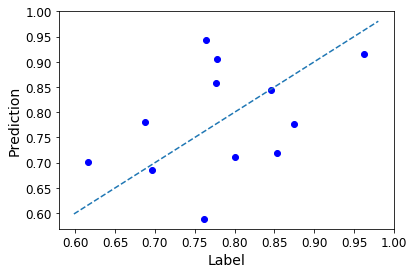

'TRAIN'


,Oxaliplatin,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
22,1.000000,-0.687761,-0.168264,-0.687761,0.610562,0.413320,-0.687761,-0.594423,0.413320,-0.665786,...,-0.069208,0.745745,0.540231,-0.043792,-0.675757,0.321580,-0.687761,-0.109327,-0.127176,-0.507996
49,0.862368,-0.020034,-0.961592,-0.020034,0.074847,-0.803470,-0.942163,-0.772674,-0.031977,0.204102,...,0.057633,0.060901,0.060901,0.031999,0.236475,0.328670,-0.020034,0.236475,-0.001518,0.088920
5,0.943585,-0.317676,-0.335440,0.209293,-0.216357,-0.142599,-0.312554,-1.122099,-0.142599,-0.290042,...,-1.161434,-0.275555,-0.275555,-0.226220,-0.276976,0.585919,0.209293,-0.276976,-0.294952,1.978577
80,0.919561,-0.500974,-0.107925,-0.500974,0.816153,-1.413008,-0.552127,-0.482102,0.175856,-0.392976,...,-0.026517,0.302397,0.302397,0.398799,-0.113278,0.496564,-0.500974,0.327621,-0.180671,0.461373
54,0.950017,-0.806901,-0.880542,-0.020839,0.132060,-0.754354,-0.867598,-0.800971,-0.681996,0.069571,...,0.070007,0.046111,0.046111,0.161423,0.046642,0.209179,-0.036933,0.046642,0.025277,0.083573
55,0.746754,0.082445,-0.003601,0.082445,-0.865438,0.149928,-0.835642,-0.851518,0.149928,0.038660,...,0.096341,0.097715,0.097715,0.089291,0.045415,0.156436,0.082445,0.045415,0.045845,0.092587
25,0.782240,-0.114785,-0.766630,-0.114785,-0.014794,-0.942306,-0.114785,-0.020771,0.076786,-0.077897,...,-0.037696,-0.021466,-0.021466,0.009035,-0.080904,-0.037473,-0.114785,0.512414,-0.108519,0.554319
88,0.912904,-0.050292,-0.786044,-0.050292,0.115949,0.140157,-0.934786,0.089257,0.140157,-0.010953,...,0.023000,0.052496,0.052496,0.150978,-0.625073,0.091585,-0.050292,0.470041,-0.045214,2.670349
7,0.914860,0.130872,-0.214090,0.130872,0.284643,-1.540337,-0.691314,-1.599590,-1.540337,-0.166528,...,-0.685718,0.278768,0.278768,0.246764,-0.720195,0.331348,0.130872,0.247601,-0.773288,0.301806
64,0.967485,-0.012868,0.047372,-0.012868,-0.888016,-0.777683,-0.935657,-0.840856,0.128660,0.025474,...,0.696931,0.068836,0.068836,0.091332,-0.953096,0.092601,-0.012868,0.609261,0.001875,0.093665


'TEST'


,Oxaliplatin,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
66,0.728443,0.119767,0.117106,0.125298,-0.011011,-0.649209,-0.801089,-4.708567,0.269753,-0.088666,...,-1.123365,0.274711,0.147736,0.111191,-0.567861,0.214383,0.051350,0.434780,-0.819149,0.775192
81,0.874615,0.111113,-0.279427,0.111113,0.223442,-1.598806,-0.788369,-0.711756,-0.040352,-0.745530,...,0.246913,0.469116,-0.201600,0.218948,-0.199229,0.227719,0.111113,-0.199229,-0.222383,0.788834
59,0.845388,-0.127138,0.220051,-0.127138,-0.021930,-0.579671,-0.652698,-1.479701,0.314225,0.240669,...,0.309550,0.680145,-0.075069,0.292756,-0.664100,0.340519,-0.127138,-0.109071,-0.661613,0.307169
24,0.799478,-0.156418,-0.934739,-0.192056,0.465939,-0.007093,-1.061507,-0.031043,-0.007093,-0.178400,...,0.436394,0.936001,-0.982212,-0.175701,-0.155148,0.861397,-0.192056,0.786487,-0.537990,0.595749
32,0.939280,0.088577,0.048355,0.088577,0.181035,-0.343950,-0.450134,-0.389765,-0.343950,0.096573,...,0.163542,0.085605,0.085605,-0.417234,-0.445309,0.584467,0.088577,0.505502,-0.481497,0.543635
51,0.839335,-0.051102,-0.634563,-0.051102,0.408911,-0.423337,-0.592335,-0.640060,-0.423337,0.393275,...,0.003425,0.444855,-0.002862,0.070373,-0.551927,0.461309,-0.051102,0.370142,-0.614964,0.480710
17,0.800729,0.135596,-0.306661,0.135596,0.250250,-0.634707,-0.761605,-0.518442,0.340132,0.144331,...,0.228484,-0.098005,-0.098005,0.138078,-0.789171,0.319532,0.135596,0.192220,-0.241952,-0.258214
16,0.911643,0.017521,-0.945842,0.017521,0.088437,-0.735902,-0.897756,-0.840457,0.158708,0.066237,...,0.111495,0.103504,0.103504,0.139750,-0.215921,0.245245,0.017521,0.108563,-0.937334,0.138085
36,0.755721,-0.095374,-0.932848,-0.189183,0.072031,0.183853,-0.133161,-0.850514,-0.203573,-0.052652,...,-0.023662,0.511466,-0.234993,1.436124,-0.843295,0.638713,0.666291,-0.006116,-0.913696,0.516436
29,0.924399,0.029959,0.318227,-0.037934,-0.054207,-0.764015,-0.803408,0.065922,0.200720,-0.008995,...,-0.812448,0.147939,-0.074936,-0.421161,-0.864290,0.032801,-0.037934,0.375272,-0.980785,0.425974


RMSE: 0.0971505082099
Pearson: (-0.14614349434706228, 0.65039695362400218)
Spearman: SpearmanrResult(correlation=-0.10489510489510491, pvalue=0.74560948098070789)


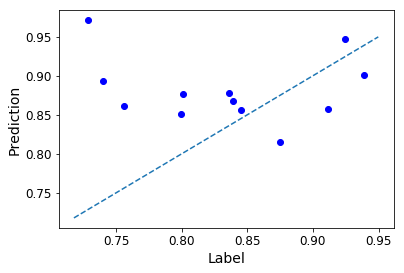

In [52]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.20)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.8))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Visualize ML results using Random Forest Regressor

'TRAIN'


,Gemcitabine,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
22,0.915466,-0.687761,-0.168264,-0.687761,0.610562,0.413320,-0.687761,-0.594423,0.413320,-0.665786,...,-0.069208,0.745745,0.540231,-0.043792,-0.675757,0.321580,-0.687761,-0.109327,-0.127176,-0.507996
37,0.719214,-0.392842,-0.354415,-0.302484,-0.350955,-0.245918,-0.393558,-0.325803,-0.245918,-0.367840,...,-0.323704,0.412507,-0.287018,1.300455,-0.403672,0.504925,0.503716,0.146761,-0.459272,0.599997
32,0.736595,0.088577,0.048355,0.088577,0.181035,-0.343950,-0.450134,-0.389765,-0.343950,0.096573,...,0.163542,0.085605,0.085605,-0.417234,-0.445309,0.584467,0.088577,0.505502,-0.481497,0.543635
81,0.592928,0.111113,-0.279427,0.111113,0.223442,-1.598806,-0.788369,-0.711756,-0.040352,-0.745530,...,0.246913,0.469116,-0.201600,0.218948,-0.199229,0.227719,0.111113,-0.199229,-0.222383,0.788834
19,0.680200,0.027393,-0.543165,0.027393,0.270013,-1.429431,-0.727629,-1.352894,0.015393,-0.451992,...,-0.072607,0.420460,-1.316621,0.463309,-0.213237,0.124904,0.027393,0.298176,-0.533831,1.557450
21,0.597597,-0.624372,-0.696986,-0.624372,0.644341,-1.404413,-0.624372,-0.471252,0.165918,-0.061169,...,0.000564,0.997109,-0.526829,0.412547,0.371748,0.340259,-0.624372,0.365421,-0.114467,0.957819
70,0.790540,-0.038424,0.085582,0.100625,0.247720,-0.634960,0.100625,-0.640472,0.800277,0.114773,...,-0.737542,0.261146,0.261146,0.307835,0.123319,0.271900,-0.038424,0.123319,-0.801357,0.274833
4,0.694529,-0.031502,-0.040405,-0.031502,0.070919,-0.790087,-0.934074,-0.869327,0.093761,0.552080,...,0.056422,0.041050,0.041050,0.072801,0.014393,0.075673,-0.031502,0.014393,-1.011516,0.667773
14,0.613860,0.005322,-0.030732,0.005322,0.085692,0.137097,0.005322,-0.928042,0.137097,0.020967,...,0.055584,0.072988,0.072988,0.089219,-0.919188,0.081243,0.005322,0.042071,-0.013083,0.079147
27,0.721026,0.076952,-0.850313,0.037689,0.173123,-0.732659,-0.839091,-0.792946,0.182014,0.087178,...,0.129737,0.104021,0.104021,-0.829159,-0.892941,0.729033,0.037689,0.087438,-0.868644,0.206997


'TEST'


,Gemcitabine,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
38,0.659406,-0.052143,-0.064653,-0.052143,0.068681,-0.834527,-0.960793,0.074921,0.135028,-0.004466,...,0.601841,0.066401,-0.949093,0.066245,0.010764,0.616187,-0.052143,0.030825,-0.993734,0.653767
30,0.637520,-0.154674,-0.232101,-0.222955,-0.014822,-0.616782,-0.725121,-0.682573,0.316372,0.387433,...,0.085986,-0.144294,-0.144294,0.253875,0.195634,0.375740,-0.222955,0.138105,-0.154725,0.569999
69,0.636072,0.151161,-0.202464,0.151161,0.149548,-0.666433,-0.819462,-4.797616,1.341327,0.124778,...,-0.138331,0.175487,0.175487,-0.100306,0.182718,0.787357,0.151161,0.182718,-0.191201,0.179012
48,0.588977,-0.349416,0.335585,0.349797,-0.255805,-0.810489,-0.886640,-0.285123,-0.810489,0.338413,...,0.306817,0.538407,0.331331,-0.025380,-0.353175,0.716334,-0.457964,0.305106,-0.337257,1.246137
3,0.677571,-0.243281,-0.597811,-0.243281,0.252588,-0.494849,-0.770950,-1.530490,0.339811,0.254311,...,0.354180,0.174530,0.173222,0.389187,-0.680256,0.231183,-0.243281,-0.070620,-0.257258,0.694761
89,0.690240,-0.012601,-0.006561,-0.012601,0.111773,-0.724117,-0.796885,-0.638010,0.642113,0.100225,...,0.101900,0.083214,0.083214,0.100712,0.065016,0.114578,-0.012601,0.995670,0.035621,0.160703
10,0.750907,-0.211088,-0.788262,-0.779782,0.264241,-0.622085,-0.751206,-0.697975,0.272377,0.192339,...,0.249699,0.561605,-0.164773,0.287506,0.204379,0.587367,-0.779782,0.204379,-0.193646,0.238656
29,0.683129,0.029959,0.318227,-0.037934,-0.054207,-0.764015,-0.803408,0.065922,0.200720,-0.008995,...,-0.812448,0.147939,-0.074936,-0.421161,-0.864290,0.032801,-0.037934,0.375272,-0.980785,0.425974
6,0.619415,0.151620,0.166565,0.151620,0.058378,-0.510946,-0.786721,-0.616592,0.434166,0.163978,...,0.176326,0.192074,0.192074,0.277968,0.092862,0.243589,0.151620,0.092862,-0.152091,-0.115525
71,0.626015,-0.346194,-0.290054,-0.353157,0.298872,-1.134960,-0.353157,-2.685935,0.356224,-0.306666,...,0.238203,0.725686,-0.290913,-0.220279,-0.300379,0.716214,-0.353157,0.332363,-0.385538,0.775978


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0441275097676
Pearson: (0.25042558393912079, 0.48527519257065194)
Spearman: SpearmanrResult(correlation=0.066666666666666652, pvalue=0.85481308824874258)


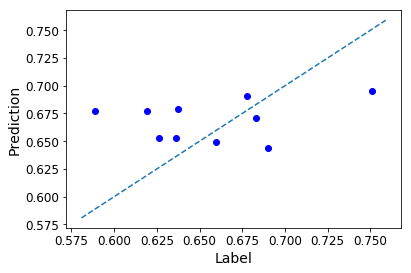

'TRAIN'


,Paclitaxel,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
62,0.685397,0.460942,-0.534591,0.460942,-0.409876,-0.362262,-0.472703,-0.417341,-0.362262,-0.478336,...,0.132005,-0.428548,-0.428548,0.514538,0.088936,0.561241,0.460942,0.088936,-0.444778,0.762311
2,0.748410,0.566340,-0.589751,0.566340,-0.794380,-1.594234,-0.819717,0.238720,0.715618,-0.104585,...,-0.173821,0.047661,0.047661,0.557542,0.012622,0.825662,0.566340,0.548530,-0.320209,0.351739
93,0.558231,-0.863421,-0.006058,0.007567,0.204189,-0.861453,-0.855914,-0.776960,0.121456,0.055273,...,0.124049,0.125803,0.125803,0.019619,-0.893810,0.169023,0.007567,0.098383,0.022979,0.550465
19,0.577722,0.027393,-0.543165,0.027393,0.270013,-1.429431,-0.727629,-1.352894,0.015393,-0.451992,...,-0.072607,0.420460,-1.316621,0.463309,-0.213237,0.124904,0.027393,0.298176,-0.533831,1.557450
37,0.706000,-0.392842,-0.354415,-0.302484,-0.350955,-0.245918,-0.393558,-0.325803,-0.245918,-0.367840,...,-0.323704,0.412507,-0.287018,1.300455,-0.403672,0.504925,0.503716,0.146761,-0.459272,0.599997
65,0.588074,0.086752,-0.851427,0.086752,0.164449,-0.792466,-0.820878,-0.787761,0.212358,0.083198,...,0.133240,0.245965,0.072348,-0.256036,-0.863858,0.296249,0.086752,0.653934,-0.935416,0.120532
80,0.722832,-0.500974,-0.107925,-0.500974,0.816153,-1.413008,-0.552127,-0.482102,0.175856,-0.392976,...,-0.026517,0.302397,0.302397,0.398799,-0.113278,0.496564,-0.500974,0.327621,-0.180671,0.461373
63,0.659587,-0.894292,0.031113,-0.212213,0.076011,-0.770014,-0.870799,-4.926428,0.327271,0.041336,...,0.092166,0.095401,0.095401,0.159637,0.107283,0.104881,-0.212213,0.104274,-1.005195,0.380132
82,0.641439,-0.102631,-0.154147,-0.102631,0.050138,0.080852,-0.102631,0.026502,0.080852,-0.027111,...,0.037679,-0.031129,-0.031129,0.067826,0.009180,0.053886,-0.102631,0.009180,-0.136665,0.090094
38,0.645487,-0.052143,-0.064653,-0.052143,0.068681,-0.834527,-0.960793,0.074921,0.135028,-0.004466,...,0.601841,0.066401,-0.949093,0.066245,0.010764,0.616187,-0.052143,0.030825,-0.993734,0.653767


'TEST'


,Paclitaxel,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
25,0.592818,-0.114785,-0.766630,-0.114785,-0.014794,-0.942306,-0.114785,-0.020771,0.076786,-0.077897,...,-0.037696,-0.021466,-0.021466,0.009035,-0.080904,-0.037473,-0.114785,0.512414,-0.108519,0.554319
4,0.653745,-0.031502,-0.040405,-0.031502,0.070919,-0.790087,-0.934074,-0.869327,0.093761,0.552080,...,0.056422,0.041050,0.041050,0.072801,0.014393,0.075673,-0.031502,0.014393,-1.011516,0.667773
0,0.715357,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854
50,0.561322,0.286718,-1.576893,0.674587,0.692968,-0.156040,-0.643627,-0.541235,-0.156040,-0.063084,...,-0.082957,0.352909,0.352909,0.017448,-0.139133,0.077701,0.674587,0.648257,0.048668,-0.535573
49,0.575363,-0.020034,-0.961592,-0.020034,0.074847,-0.803470,-0.942163,-0.772674,-0.031977,0.204102,...,0.057633,0.060901,0.060901,0.031999,0.236475,0.328670,-0.020034,0.236475,-0.001518,0.088920
32,0.697379,0.088577,0.048355,0.088577,0.181035,-0.343950,-0.450134,-0.389765,-0.343950,0.096573,...,0.163542,0.085605,0.085605,-0.417234,-0.445309,0.584467,0.088577,0.505502,-0.481497,0.543635
55,0.545283,0.082445,-0.003601,0.082445,-0.865438,0.149928,-0.835642,-0.851518,0.149928,0.038660,...,0.096341,0.097715,0.097715,0.089291,0.045415,0.156436,0.082445,0.045415,0.045845,0.092587
88,0.579235,-0.050292,-0.786044,-0.050292,0.115949,0.140157,-0.934786,0.089257,0.140157,-0.010953,...,0.023000,0.052496,0.052496,0.150978,-0.625073,0.091585,-0.050292,0.470041,-0.045214,2.670349
51,0.630910,-0.051102,-0.634563,-0.051102,0.408911,-0.423337,-0.592335,-0.640060,-0.423337,0.393275,...,0.003425,0.444855,-0.002862,0.070373,-0.551927,0.461309,-0.051102,0.370142,-0.614964,0.480710
64,0.593731,-0.012868,0.047372,-0.012868,-0.888016,-0.777683,-0.935657,-0.840856,0.128660,0.025474,...,0.696931,0.068836,0.068836,0.091332,-0.953096,0.092601,-0.012868,0.609261,0.001875,0.093665


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.050880005617
Pearson: (0.53701269208239988, 0.10946019833179586)
Spearman: SpearmanrResult(correlation=0.41818181818181815, pvalue=0.22911284098281892)


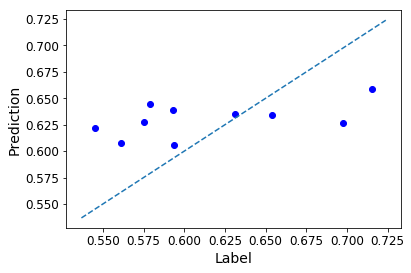

'TRAIN'


,SN-38,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
63,0.641930,-0.894292,0.031113,-0.212213,0.076011,-0.770014,-0.870799,-4.926428,0.327271,0.041336,...,0.092166,0.095401,0.095401,0.159637,0.107283,0.104881,-0.212213,0.104274,-1.005195,0.380132
69,0.549987,0.151161,-0.202464,0.151161,0.149548,-0.666433,-0.819462,-4.797616,1.341327,0.124778,...,-0.138331,0.175487,0.175487,-0.100306,0.182718,0.787357,0.151161,0.182718,-0.191201,0.179012
26,0.655725,-0.087993,-0.481853,-0.087993,0.379758,-1.404059,-0.621987,-0.531713,0.402596,0.318321,...,-0.001358,0.367263,0.367263,0.345299,-5.145469,0.042251,-0.087993,0.363623,-0.678297,0.444689
70,0.814614,-0.038424,0.085582,0.100625,0.247720,-0.634960,0.100625,-0.640472,0.800277,0.114773,...,-0.737542,0.261146,0.261146,0.307835,0.123319,0.271900,-0.038424,0.123319,-0.801357,0.274833
10,0.711736,-0.211088,-0.788262,-0.779782,0.264241,-0.622085,-0.751206,-0.697975,0.272377,0.192339,...,0.249699,0.561605,-0.164773,0.287506,0.204379,0.587367,-0.779782,0.204379,-0.193646,0.238656
55,0.489531,0.082445,-0.003601,0.082445,-0.865438,0.149928,-0.835642,-0.851518,0.149928,0.038660,...,0.096341,0.097715,0.097715,0.089291,0.045415,0.156436,0.082445,0.045415,0.045845,0.092587
81,0.602550,0.111113,-0.279427,0.111113,0.223442,-1.598806,-0.788369,-0.711756,-0.040352,-0.745530,...,0.246913,0.469116,-0.201600,0.218948,-0.199229,0.227719,0.111113,-0.199229,-0.222383,0.788834
82,0.646083,-0.102631,-0.154147,-0.102631,0.050138,0.080852,-0.102631,0.026502,0.080852,-0.027111,...,0.037679,-0.031129,-0.031129,0.067826,0.009180,0.053886,-0.102631,0.009180,-0.136665,0.090094
0,0.542345,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854
24,0.560497,-0.156418,-0.934739,-0.192056,0.465939,-0.007093,-1.061507,-0.031043,-0.007093,-0.178400,...,0.436394,0.936001,-0.982212,-0.175701,-0.155148,0.861397,-0.192056,0.786487,-0.537990,0.595749


'TEST'


,SN-38,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
88,0.586283,-0.050292,-0.786044,-0.050292,0.115949,0.140157,-0.934786,0.089257,0.140157,-0.010953,...,0.023000,0.052496,0.052496,0.150978,-0.625073,0.091585,-0.050292,0.470041,-0.045214,2.670349
21,0.621525,-0.624372,-0.696986,-0.624372,0.644341,-1.404413,-0.624372,-0.471252,0.165918,-0.061169,...,0.000564,0.997109,-0.526829,0.412547,0.371748,0.340259,-0.624372,0.365421,-0.114467,0.957819
17,0.555850,0.135596,-0.306661,0.135596,0.250250,-0.634707,-0.761605,-0.518442,0.340132,0.144331,...,0.228484,-0.098005,-0.098005,0.138078,-0.789171,0.319532,0.135596,0.192220,-0.241952,-0.258214
80,0.635591,-0.500974,-0.107925,-0.500974,0.816153,-1.413008,-0.552127,-0.482102,0.175856,-0.392976,...,-0.026517,0.302397,0.302397,0.398799,-0.113278,0.496564,-0.500974,0.327621,-0.180671,0.461373
6,0.548342,0.151620,0.166565,0.151620,0.058378,-0.510946,-0.786721,-0.616592,0.434166,0.163978,...,0.176326,0.192074,0.192074,0.277968,0.092862,0.243589,0.151620,0.092862,-0.152091,-0.115525
64,0.578875,-0.012868,0.047372,-0.012868,-0.888016,-0.777683,-0.935657,-0.840856,0.128660,0.025474,...,0.696931,0.068836,0.068836,0.091332,-0.953096,0.092601,-0.012868,0.609261,0.001875,0.093665
5,0.570326,-0.317676,-0.335440,0.209293,-0.216357,-0.142599,-0.312554,-1.122099,-0.142599,-0.290042,...,-1.161434,-0.275555,-0.275555,-0.226220,-0.276976,0.585919,0.209293,-0.276976,-0.294952,1.978577
18,0.566709,0.132319,-0.253738,0.132319,0.199560,-1.575238,-0.737578,-4.994624,0.264323,0.147926,...,-0.143308,0.234535,0.234535,0.235307,-0.685288,0.240842,0.132319,0.273304,-0.210431,0.266274
38,0.632628,-0.052143,-0.064653,-0.052143,0.068681,-0.834527,-0.960793,0.074921,0.135028,-0.004466,...,0.601841,0.066401,-0.949093,0.066245,0.010764,0.616187,-0.052143,0.030825,-0.993734,0.653767
36,0.622144,-0.095374,-0.932848,-0.189183,0.072031,0.183853,-0.133161,-0.850514,-0.203573,-0.052652,...,-0.023662,0.511466,-0.234993,1.436124,-0.843295,0.638713,0.666291,-0.006116,-0.913696,0.516436


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0438390791783
Pearson: (0.16643932137882009, 0.64583337784585559)
Spearman: SpearmanrResult(correlation=-0.018181818181818181, pvalue=0.96024041812862426)


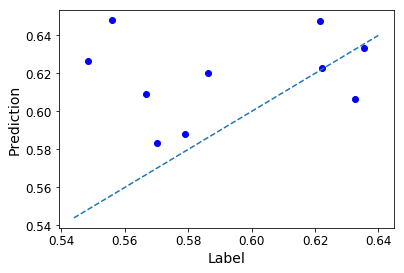

'TRAIN'


,5-FU,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
49,0.661599,-0.020034,-0.961592,-0.020034,0.074847,-0.803470,-0.942163,-0.772674,-0.031977,0.204102,...,0.057633,0.060901,0.060901,0.031999,0.236475,0.328670,-0.020034,0.236475,-0.001518,0.088920
19,0.742902,0.027393,-0.543165,0.027393,0.270013,-1.429431,-0.727629,-1.352894,0.015393,-0.451992,...,-0.072607,0.420460,-1.316621,0.463309,-0.213237,0.124904,0.027393,0.298176,-0.533831,1.557450
34,0.583491,0.060279,0.032217,0.060279,-0.356293,-0.351909,-0.453616,-0.408758,-0.351909,0.046640,...,0.145157,0.123357,0.123357,-0.409267,-0.409423,0.552771,0.060279,0.478386,-0.493038,0.519174
50,0.845183,0.286718,-1.576893,0.674587,0.692968,-0.156040,-0.643627,-0.541235,-0.156040,-0.063084,...,-0.082957,0.352909,0.352909,0.017448,-0.139133,0.077701,0.674587,0.648257,0.048668,-0.535573
70,0.875244,-0.038424,0.085582,0.100625,0.247720,-0.634960,0.100625,-0.640472,0.800277,0.114773,...,-0.737542,0.261146,0.261146,0.307835,0.123319,0.271900,-0.038424,0.123319,-0.801357,0.274833
35,0.655291,-0.714736,-0.648772,-0.721877,0.297124,-0.559314,-0.695849,-0.631595,-0.559314,0.260243,...,-0.094369,0.334178,-0.675151,1.408859,-0.686627,0.319508,0.478637,0.598293,-0.187694,0.640989
69,0.762266,0.151161,-0.202464,0.151161,0.149548,-0.666433,-0.819462,-4.797616,1.341327,0.124778,...,-0.138331,0.175487,0.175487,-0.100306,0.182718,0.787357,0.151161,0.182718,-0.191201,0.179012
29,0.888039,0.029959,0.318227,-0.037934,-0.054207,-0.764015,-0.803408,0.065922,0.200720,-0.008995,...,-0.812448,0.147939,-0.074936,-0.421161,-0.864290,0.032801,-0.037934,0.375272,-0.980785,0.425974
23,0.735328,0.048564,-0.152602,0.048564,0.344240,-1.498079,-0.651957,-0.487487,-0.166071,0.152892,...,-0.140271,0.376224,-0.087151,-0.080004,-0.661116,0.358696,0.048564,-0.095923,-0.673797,-0.094925
10,0.800295,-0.211088,-0.788262,-0.779782,0.264241,-0.622085,-0.751206,-0.697975,0.272377,0.192339,...,0.249699,0.561605,-0.164773,0.287506,0.204379,0.587367,-0.779782,0.204379,-0.193646,0.238656


'TEST'


,5-FU,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
7,0.895087,0.130872,-0.214090,0.130872,0.284643,-1.540337,-0.691314,-1.599590,-1.540337,-0.166528,...,-0.685718,0.278768,0.278768,0.246764,-0.720195,0.331348,0.130872,0.247601,-0.773288,0.301806
64,0.817725,-0.012868,0.047372,-0.012868,-0.888016,-0.777683,-0.935657,-0.840856,0.128660,0.025474,...,0.696931,0.068836,0.068836,0.091332,-0.953096,0.092601,-0.012868,0.609261,0.001875,0.093665
37,0.833724,-0.392842,-0.354415,-0.302484,-0.350955,-0.245918,-0.393558,-0.325803,-0.245918,-0.367840,...,-0.323704,0.412507,-0.287018,1.300455,-0.403672,0.504925,0.503716,0.146761,-0.459272,0.599997
2,0.673957,0.566340,-0.589751,0.566340,-0.794380,-1.594234,-0.819717,0.238720,0.715618,-0.104585,...,-0.173821,0.047661,0.047661,0.557542,0.012622,0.825662,0.566340,0.548530,-0.320209,0.351739
88,0.739124,-0.050292,-0.786044,-0.050292,0.115949,0.140157,-0.934786,0.089257,0.140157,-0.010953,...,0.023000,0.052496,0.052496,0.150978,-0.625073,0.091585,-0.050292,0.470041,-0.045214,2.670349
55,0.726636,0.082445,-0.003601,0.082445,-0.865438,0.149928,-0.835642,-0.851518,0.149928,0.038660,...,0.096341,0.097715,0.097715,0.089291,0.045415,0.156436,0.082445,0.045415,0.045845,0.092587
81,0.621484,0.111113,-0.279427,0.111113,0.223442,-1.598806,-0.788369,-0.711756,-0.040352,-0.745530,...,0.246913,0.469116,-0.201600,0.218948,-0.199229,0.227719,0.111113,-0.199229,-0.222383,0.788834
6,0.755120,0.151620,0.166565,0.151620,0.058378,-0.510946,-0.786721,-0.616592,0.434166,0.163978,...,0.176326,0.192074,0.192074,0.277968,0.092862,0.243589,0.151620,0.092862,-0.152091,-0.115525
84,0.615629,0.353739,-0.619910,0.353739,0.027911,-1.286362,-0.550712,-0.441061,-1.284279,0.022348,...,-0.433284,0.505116,-0.494379,-0.401544,-0.538279,0.515756,0.353739,0.041120,-0.558424,1.510324


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0973608875596
Pearson: (0.053901920879695565, 0.8904574262494267)
Spearman: SpearmanrResult(correlation=-0.13333333333333333, pvalue=0.73236750523629746)


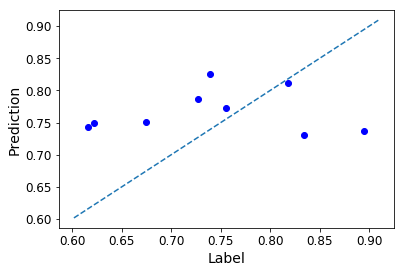

'TRAIN'


,Oxaliplatin,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
17,0.800729,0.135596,-0.306661,0.135596,0.250250,-0.634707,-0.761605,-0.518442,0.340132,0.144331,...,0.228484,-0.098005,-0.098005,0.138078,-0.789171,0.319532,0.135596,0.192220,-0.241952,-0.258214
70,0.838208,-0.038424,0.085582,0.100625,0.247720,-0.634960,0.100625,-0.640472,0.800277,0.114773,...,-0.737542,0.261146,0.261146,0.307835,0.123319,0.271900,-0.038424,0.123319,-0.801357,0.274833
71,0.914314,-0.346194,-0.290054,-0.353157,0.298872,-1.134960,-0.353157,-2.685935,0.356224,-0.306666,...,0.238203,0.725686,-0.290913,-0.220279,-0.300379,0.716214,-0.353157,0.332363,-0.385538,0.775978
4,0.813800,-0.031502,-0.040405,-0.031502,0.070919,-0.790087,-0.934074,-0.869327,0.093761,0.552080,...,0.056422,0.041050,0.041050,0.072801,0.014393,0.075673,-0.031502,0.014393,-1.011516,0.667773
67,0.896108,-0.461671,0.059738,-0.461671,-0.397129,-0.312624,-0.461671,-0.394596,-0.312624,-0.427314,...,0.154809,0.167920,0.167920,-0.369718,0.130418,0.566756,-0.461671,0.130418,-1.317015,0.172944
22,1.000000,-0.687761,-0.168264,-0.687761,0.610562,0.413320,-0.687761,-0.594423,0.413320,-0.665786,...,-0.069208,0.745745,0.540231,-0.043792,-0.675757,0.321580,-0.687761,-0.109327,-0.127176,-0.507996
21,0.795722,-0.624372,-0.696986,-0.624372,0.644341,-1.404413,-0.624372,-0.471252,0.165918,-0.061169,...,0.000564,0.997109,-0.526829,0.412547,0.371748,0.340259,-0.624372,0.365421,-0.114467,0.957819
68,0.791185,-0.020544,0.482965,-0.020544,0.075696,-0.797461,-0.955926,0.055713,0.210702,0.012291,...,0.065207,0.070398,0.070398,-0.845527,0.043855,0.076861,-0.020544,0.043855,-0.055865,0.068069
1,0.802963,0.463318,-0.332190,0.226877,-0.240739,-0.973241,-0.334562,-0.242026,1.636246,-0.706995,...,0.255607,0.225913,0.225913,-0.256202,0.179031,0.526987,0.226877,0.425506,-0.330152,-0.255410
18,0.850711,0.132319,-0.253738,0.132319,0.199560,-1.575238,-0.737578,-4.994624,0.264323,0.147926,...,-0.143308,0.234535,0.234535,0.235307,-0.685288,0.240842,0.132319,0.273304,-0.210431,0.266274


'TEST'


,Oxaliplatin,RNF43,RREB1,NF1,PALB2,SMAD4,TP53,CDKN2A,GATA6,MAP2K1,...,ATM,EGFR,PRSS1,BRCA2,TGFBR2,GNAS,BRCA1,PIK3CA,ARID1A,MYC
27,0.814672,0.076952,-0.850313,0.037689,0.173123,-0.732659,-0.839091,-0.792946,0.182014,0.087178,...,0.129737,0.104021,0.104021,-0.829159,-0.892941,0.729033,0.037689,0.087438,-0.868644,0.206997
33,0.924407,0.042932,0.006260,0.042932,-0.408587,0.110811,-0.475180,-0.373749,0.110811,0.376944,...,0.136926,0.560028,0.085808,-0.436133,-0.471923,0.725885,0.042932,0.463375,-0.504340,0.206408
49,0.862368,-0.020034,-0.961592,-0.020034,0.074847,-0.803470,-0.942163,-0.772674,-0.031977,0.204102,...,0.057633,0.060901,0.060901,0.031999,0.236475,0.328670,-0.020034,0.236475,-0.001518,0.088920
38,0.780229,-0.052143,-0.064653,-0.052143,0.068681,-0.834527,-0.960793,0.074921,0.135028,-0.004466,...,0.601841,0.066401,-0.949093,0.066245,0.010764,0.616187,-0.052143,0.030825,-0.993734,0.653767
50,0.740179,0.286718,-1.576893,0.674587,0.692968,-0.156040,-0.643627,-0.541235,-0.156040,-0.063084,...,-0.082957,0.352909,0.352909,0.017448,-0.139133,0.077701,0.674587,0.648257,0.048668,-0.535573
59,0.845388,-0.127138,0.220051,-0.127138,-0.021930,-0.579671,-0.652698,-1.479701,0.314225,0.240669,...,0.309550,0.680145,-0.075069,0.292756,-0.664100,0.340519,-0.127138,-0.109071,-0.661613,0.307169
80,0.919561,-0.500974,-0.107925,-0.500974,0.816153,-1.413008,-0.552127,-0.482102,0.175856,-0.392976,...,-0.026517,0.302397,0.302397,0.398799,-0.113278,0.496564,-0.500974,0.327621,-0.180671,0.461373
65,0.907493,0.086752,-0.851427,0.086752,0.164449,-0.792466,-0.820878,-0.787761,0.212358,0.083198,...,0.133240,0.245965,0.072348,-0.256036,-0.863858,0.296249,0.086752,0.653934,-0.935416,0.120532
0,0.875863,0.000254,-0.967236,0.000254,0.102201,-0.770160,0.054688,0.062045,-0.770160,0.022170,...,0.046421,0.063498,0.059827,-0.734935,0.035420,0.274217,0.000254,0.035420,-0.963255,1.649854


c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RMSE: 0.0586777364841
Pearson: (0.40927591343538938, 0.27402009773028102)
Spearman: SpearmanrResult(correlation=0.33333333333333337, pvalue=0.38071318167686341)


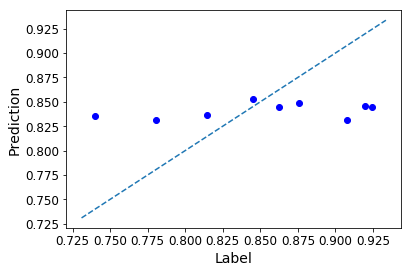

In [41]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.15)
    
    display_set(X_TRAIN, X_TEST, Y_TRAIN, Y_TEST)
        
    Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=8))
    
    y_test_np, y_prediction, this_y_train_tr = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)

    rmse, r, t = simple_score(y_test_np, y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))

    #scores = cv_score(XYpipeline, X_TRAIN, this_y_train_tr)
    
    #print("CV Scores: " + str(scores))
    #print("CV Mean: " + str(scores.mean()))
    #print("CV STD: " + str(scores.std()))
             
    visualize(y_test_np, y_prediction)


### Bootstrap Regression Model

RMSE: 0.106059649095
Pearson: (0.23990518808627367, 0.058249454236327006)
Spearman: SpearmanrResult(correlation=0.28783770554836691, pvalue=0.022164532110196311)


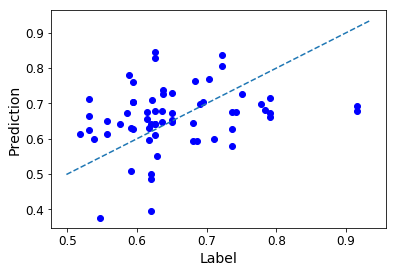

RMSE: 0.0849801852139
Pearson: (0.18164373687576976, 0.15422525516493638)
Spearman: SpearmanrResult(correlation=0.19458786167429595, pvalue=0.12645950372216744)


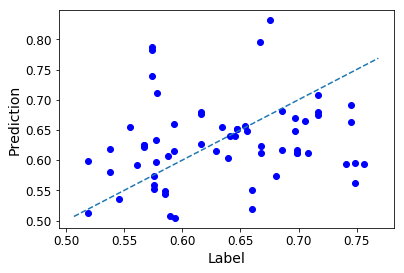

RMSE: 0.0884273184356
Pearson: (0.21902264148065609, 0.084593379335798455)
Spearman: SpearmanrResult(correlation=0.26334180360650117, pvalue=0.037040486437817988)


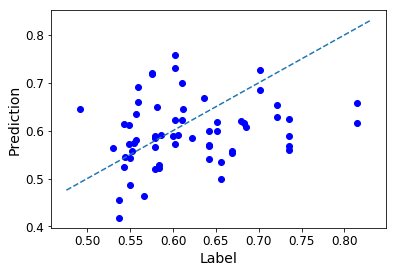

RMSE: 0.112446767568
Pearson: (0.056990510767753001, 0.68229991756010189)
Spearman: SpearmanrResult(correlation=-0.045392138866716294, pvalue=0.74448048493197616)


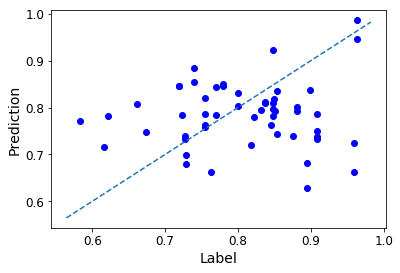

RMSE: 0.0899877097112
Pearson: (0.1605649705837664, 0.24611303454420835)
Spearman: SpearmanrResult(correlation=0.15427451731767902, pvalue=0.26534829317967734)


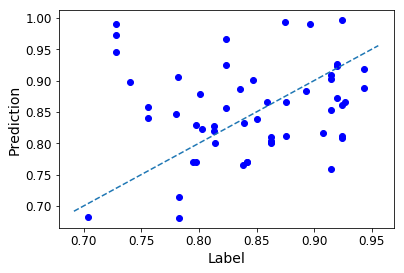

In [39]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("ridge_model", Ridge(alpha = 0.50))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)


### Bootstrap Random Forest Model

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0711386310753
Pearson: (0.040834599131047145, 0.75066944258546786)
Spearman: SpearmanrResult(correlation=0.013880219025600857, pvalue=0.91401963396027708)


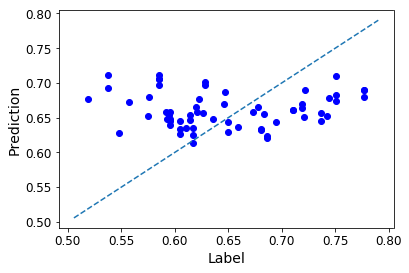

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0739350736649
Pearson: (-0.23759096381020947, 0.060792367957492835)
Spearman: SpearmanrResult(correlation=-0.23424052128434777, pvalue=0.064632053873727918)


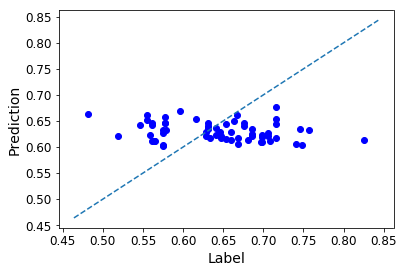

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0719370092654
Pearson: (0.07282283037777533, 0.57058337468394549)
Spearman: SpearmanrResult(correlation=0.12200249655077749, pvalue=0.34082426941957478)


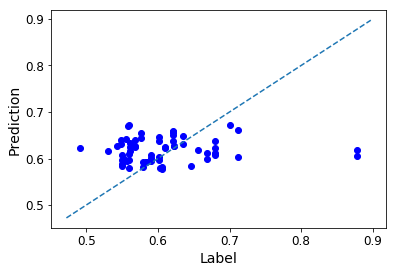

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0910053559737
Pearson: (-0.014857724090135508, 0.91508042660663702)
Spearman: SpearmanrResult(correlation=-0.0018684106390683697, pvalue=0.98930172874597067)


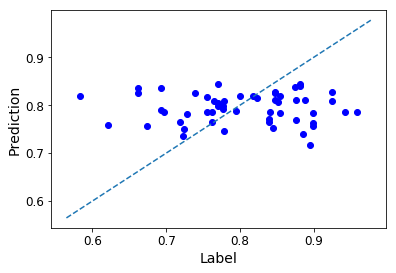

c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
c:\users\bbece\anaconda3\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RMSE: 0.0883163059969
Pearson: (-0.28661689327777146, 0.035621802193783837)
Spearman: SpearmanrResult(correlation=-0.27144630789296198, pvalue=0.047089664310731201)


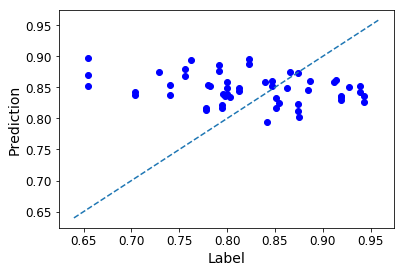

In [40]:
for label in labels:
    X_nonNA, y_nonNA = remove_NAs(X, y, label)
    
    all_y_test_np = np.array([])
    all_y_prediction = np.array([])
    for i in range(1,10):
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_nonNA, y_nonNA, test_size=0.10)

        Ypipeline, XYpipeline = retrieve_pipelines("rfs_model", RandomForestRegressor(n_estimators=1000, max_leaf_nodes=8, n_jobs=4))

        y_test_np, y_prediction, _ = train_and_test(Ypipeline, XYpipeline, X_TRAIN, X_TEST, Y_TRAIN.values, Y_TEST.values)
        all_y_test_np = np.append(all_y_test_np, y_test_np)
        all_y_prediction = np.append(all_y_prediction, y_prediction)
        
    rmse, r, t = simple_score(all_y_test_np, all_y_prediction)
    
    print("RMSE: " + str(rmse))
    print("Pearson: " + str(r))
    print("Spearman: " + str(t))
    visualize(all_y_test_np, all_y_prediction)
